# Imports

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import itertools
import random
import pickle
import sys
import matplotlib.pyplot as plt

# Check Gurobi license

In [3]:
try:

    # Create a new model
    m = gp.Model("2.17")

    # Create variables
    c = np.array([1, 2, 3])
    A = np.array([ [1, 2, 3], [1, 1, 0] ])
    b = np.array([4, 1])
    x_prev = np.array([1,2,3])
    x = m.addMVar(3, lb=0.0)
    m.setObjective(c @ x)
    m.addConstr(A@x == b)

    # Optimize model
    m.optimize()

    for v in m.getVars():
        print('%s %g' % (v.VarName, v.X))

    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-11
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0x1990d0aa
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Optimal objective  4.000000000e+00
C0 1
C1 0
C2 1
Obj: 4


# Functions

In [11]:
def min_Q_(c: dict, W: dict, h: dict, T: dict, G: dict, g: dict, x_prev: dict, k: int, t: int) -> tuple:

    """
    This function minimizes the function `c[t][k] @ x_t + phi` subject to the following constraints:

    * `W[t][k] @ x_t == h[t][k] - T[t-1][k] @ x_prev`
    * `- G[t+1] @ x_t + phi >= g[t+1]`

    Parameters TODO: Change back to dicts
    ----------
    c : numpy.ndarray
        A 2D array of cost coefficients.
    W : numpy.ndarray
        A 2D array of transition matrices.
    h : numpy.ndarray
        A 1D array of holding costs.
    T : numpy.ndarray
        A 2D array of transfer matrices.
    G : numpy.ndarray
        A 2D array of constraint matrices.
    g : numpy.ndarray
        A 1D array of constraint bounds.
    x_prev : numpy.ndarray
        A 1D array of previous state values.
    k : int
        A scenario index.
    t : int
        A time index.

    Returns
    -------
    x_t_val : numpy.ndarray
        A 1D array of optimal state values.
    obj_val : float
        The optimal objective value.
    pi : float
        The dual value of the first constraint.
    rho : float
        The dual value of the second constraint.
    phi_val: float
        The value of phi
    """

    m = gp.Model("Q_")
    
    x_t = m.addMVar(shape = len(c[t][k]), lb=0.0)
    phi = m.addVar(lb = -100)
    
    m.setObjective(c[t][k] @ x_t + phi)
    
    sequence_constraint = m.addConstr(W[t][k] @ x_t == h[t][k] - T[t-1][k] @ x_prev, name = "sequence_constraint")
    cut_constraint = m.addConstr(- G[t+1] @ x_t + phi >= g[t+1] , name = "cut_constraint") #*np.ones_like(g[t+1])
    #print(G[t+1])
    #print(g[t+1])
    m.update()
    #print(f'RHS: {cut_constraint.getAttr("RHS")}')
        
    # Solve
    m.setParam( 'OutputFlag', False )
    m.optimize()
    
    # Primal and objective value
    x_t_val = x_t.getAttr("x")
    obj_val = m.getAttr("ObjVal")
    phi_val = phi.getAttr("x")
    
    # Duals
    pi = sequence_constraint.getAttr("Pi")
    rho = cut_constraint.getAttr("Pi")

    # Return results
    return x_t_val, obj_val, pi, rho, phi_val



def initialize_cut_matrices(c: dict, phi_: dict, t_max: int) -> tuple[dict]:
    assert len(c) == t_max
    G = {}
    g = {}

    for t in range(2,t_max+1):
        G[t] = np.zeros(shape = (1, len(c[t-1][0])))
        g[t] = np.array([phi_[t]])

    G[t_max+1] = np.zeros(shape = (1, len(c[t_max][0])))
    g[t_max+1] = np.array([0])

    return G, g



def calculate_new_cut(q: dict, p: dict, h: dict[int, dict], T: dict[int, dict], 
                      pi: dict[int, dict], rho: dict[int, dict], g: dict, x: dict, Q_: dict,
                      i: int, t: int, scenario: int, i_batch: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the new cut, i.e. beta and alpha based on the input dicts and dual variables.
    
    Args:
    - q: A dictionary representing the number of elements for each time period.
    - p: A dictionary representing the probabilities of choosing an element for each time period.
    - h: A dictionary of dictionaries representing the values for each element at each time period.
    - T: A dictionary of dictionaries representing the transition matrix for each element at each time period.
    - pi: A dictionary of dictionaries of dictionaries representing the transition probabilities of each element at each time period.
    - rho: A dictionary of dictionaries of dictionaries representing the values of each constraint at each time period.
    - g: A dictionary representing the objective function values for each time period.
    
    Returns:
    A tuple containing the values of beta and alpha.
    """
    beta = - sum(p[t][j] * np.matmul(pi[i][t][scenario][j],T[t-1][j]) for j in range(q[t]))
    alpha = sum(p[t][j] * (np.matmul(pi[i][t][scenario][j],h[t][j]) + np.dot(rho[i][t][scenario][j],g[t+1])) for j in range(q[t]))
    return beta, alpha



def calculate_new_cut(q: dict, p: dict, h: dict[int, dict], T: dict[int, dict], 
                      pi: dict[int, dict], rho: dict[int, dict], g: dict, x: dict, Q_: dict,
                      i: int, t: int, scenario: int, i_batch: int) -> tuple[np.ndarray, np.ndarray]:
    """
    NEW VERSION
    Calculates the new cut, i.e. beta and alpha based on the input dicts and dual variables.
    
    Args:
    - q: A dictionary representing the number of elements for each time period.
    - p: A dictionary representing the probabilities of choosing an element for each time period.
    - h: A dictionary of dictionaries representing the values for each element at each time period.
    - T: A dictionary of dictionaries representing the transition matrix for each element at each time period.
    - pi: A dictionary of dictionaries of dictionaries representing the transition probabilities of each element at each time period.
    - rho: A dictionary of dictionaries of dictionaries representing the values of each constraint at each time period.
    - g: A dictionary representing the objective function values for each time period.
    
    Returns:
    A tuple containing the values of beta and alpha.
    """

    if i_batch is None:
        i_batch = i

    beta = sum( p[t][j] * ( -np.matmul( pi[i][t][scenario][j], T[t-1][j] ) ) for j in range(q[t]))

    # TODO: ALPHA according to new version in fuellner

    alpha = sum( p[t][j] * (Q_[i_batch][t][scenario][j] - np.dot(( -np.matmul( pi[i][t][scenario][j], T[t-1][j] ) ), x[i_batch][t-1][scenario] ) ) for j in range(q[t]) )


    # alpha_old = sum(p[t][j] * (np.matmul(pi[i][t][scenario][j],h[t][j]) + np.dot(rho[i][t][scenario][j],g[t+1])) for j in range(q[t]))
    
    # print((alpha, alpha_old))
    
    return beta, alpha



def add_cut(G_t: np.array, g_t: np.array, beta: np.array, alpha: np.array) -> tuple[np.array, np.array]:
    assert G_t.shape[0] == g_t.shape[0]
    
    G_t = np.vstack((G_t,beta))
    g_t = np.hstack((g_t,alpha))

    assert G_t.shape[0] == g_t.shape[0]

    hstacked = np.hstack((G_t,g_t[:,None]))
    hstacked_unique = np.unique(hstacked, axis=0)
    G_t = hstacked_unique[:, :-1]
    g_t = hstacked_unique[:, -1]
    return G_t, g_t



def remove_cut(G_t: np.ndarray, g_t: np.ndarray, beta: np.ndarray, alpha: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    assert G_t.shape[0] == g_t.shape[0]

    hstacked = np.hstack((G_t,g_t[:,None]))
    hstacked_unique = np.unique(hstacked, axis=0)

    plane = np.hstack((beta, alpha))
    hstacked_removed = hstacked_unique[(hstacked_unique != plane).any(axis=1)]

    G_t = hstacked_removed[:, :-1]
    g_t = hstacked_removed[:, -1]
    return G_t, g_t




def calculate_v_upper(c: dict, x_i: dict, sampled_scenarios: list, t_max: int) -> tuple[float]:

    """
    Calculates the upper bound extimate for the value v and the standard deviation of the estimator
    """
    
    v_i = {scenario: sum( np.dot(c[t][scenario[t]], x_i[t][scenario]) for t in range(1, t_max+1) ) for scenario in sampled_scenarios}
    
    v_upper_i = sum( v_i[scenario] for scenario in sampled_scenarios ) / len(sampled_scenarios)

    sigma_v_i = sum( np.square(v_i[scenario] - v_upper_i) for scenario in sampled_scenarios )
    sigma_v_i = sigma_v_i / ( (len(sampled_scenarios)-1) * len(sampled_scenarios) ) # Added to have standardisation
    sigma_v_i = np.sqrt(sigma_v_i)

    return v_upper_i, sigma_v_i


# SDDP

## Standard version

In [450]:
def SDDP(t_max: int, i_max: int, p: dict, q: dict, S: dict, c: dict, W: dict, h: dict, T: dict, phi_: np.array, no_of_samples: int, x_0: np.array) -> tuple:
    i = 0
    x = {}
    Q_ = {}
    pi = {}
    rho = {}
  
    v_lower = {}
    v_upper = {}
    sigma_v_upper = {}  

    # Initialize dicts
    for i in range(1, i_max+1):
        x[i] = {}
        Q_[i] = {}
        pi[i] = {}
        rho[i] = {}
        
        x[i][0] = {}
        # for scenario in list(S.keys()):
        #     x[i][0][scenario] = x_0
        
        for t in range(1,t_max+1):
            x[i][t] = {}
            Q_[i][t] = {}
            pi[i][t] = {}
            rho[i][t] = {}
            # for scenario in list(S.keys()):
            #     pi[i][t][scenario] = {}
            #     rho[i][t][scenario] = {}

    print(f'dicts initialized, {len(list(S.keys()))} scenarios')
    
    
    # Initialize cut matrices
    G, g = initialize_cut_matrices(c=c, phi_=phi_, t_max=t_max)
    print('cut approximations initialized')
    
    i = 1

    while i <= i_max:
        
        ## FORWARD PASS
        print(f"Forward pass: {i}")
        sampled_scenarios = random.sample(list(S.keys()), no_of_samples)
        for t in range(1,t_max+1):
            for scenario in sampled_scenarios:
                x[i][0][scenario] = x_0
                #print(f"t: {t}, scenario: {scenario}")
                k = S[scenario][t]
                x[i][t][scenario], Q_[i][t][scenario], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T, G,g, x[i][t-1][scenario],k,t) # Seems good
        
        # Calculate upper bound estimate for v
        v_upper[i], sigma_v_upper[i] = calculate_v_upper(c, x[i], sampled_scenarios, S, t_max)
        print(f"v upper {i}: {v_upper[i]}, sigma v upper {i}: {sigma_v_upper[i]}")
        print(x[i][1][scenario])
        
        
        ## BACKWARD PASS
        for t in reversed(range(2,t_max+1)):
            for scenario in sampled_scenarios:

                # Initialize duals
                pi[i][t][scenario] = {}
                rho[i][t][scenario] = {}

                Q_[i][t][scenario] = {}

                # Compute duals (pi, rho) for the scenario
                for j in range(q[t]):
                    x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][scenario],j,t)
                
                if t != 1:
                    # Calculate new cut (beta, alpha)
                    beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g,x,Q_,i,t,scenario,i)

                    # Add new cut (beta, alpha) to G, g:
                
                    G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                    
        # Finally solve stage t = 1 to get v_lower
        t = 1
        x[i][0][0] = x_0
        x[i][t][0], Q_[i][t][0], pi_temp, rho_temp, phi_val = min_Q_(c,W,h,T,G,g,x[i][t-1][0],0,t)

        v_lower[i] = Q_[i][t][0]
        print(f"v lower {i}: {v_lower[i]}")
        print(x[i][t][0])
        print(phi_val)
        i = i + 1
        
    return x, Q_, v_lower, v_upper

## Many-scenarios version

In [12]:
def sample_scenarios(t_max: int, q: dict, p: dict, no_of_samples: int, replace: bool):
    
    sampled_scenarios = []
    for s in range(no_of_samples):
        
        # 0 at 0 so that accessing with t starting from 1 gives the correct values (so list contains [0,0,x, x, x, ...])
        sample_scenario_list = [0, 0] + [ np.random.choice(a=range(q[t]), replace=replace, p=p[t]) for t in range(2, t_max+1) ]
        
        sample_scenario = tuple(sample_scenario_list)
        sampled_scenarios.append(sample_scenario)
    
    return sampled_scenarios

In [88]:
def SDDP(t_max: int, i_max: int, p: dict, q: dict, c: dict, W: dict, h: dict, T: dict, phi_: np.array, no_of_samples: int, x_0: np.array) -> tuple:
    i = 0
    x = {}
    Q_ = {}
    pi = {}
    rho = {}
  
    v_lower = {}
    v_upper = {}
    sigma_v_upper = {}  

    # Initialize dicts
    for i in range(1, i_max+1):
        x[i] = {}
        Q_[i] = {}
        pi[i] = {}
        rho[i] = {}
        
        x[i][0] = {}
        # for scenario in list(S.keys()):
        #     x[i][0][scenario] = x_0
        
        for t in range(1,t_max+1):
            x[i][t] = {}
            Q_[i][t] = {}
            pi[i][t] = {}
            rho[i][t] = {}
            # for scenario in list(S.keys()):
            #     pi[i][t][scenario] = {}
            #     rho[i][t][scenario] = {}

    #print(f'dicts initialized, {len(list(S.keys()))} scenarios')
    
    
    # Initialize cut matrices
    G, g = initialize_cut_matrices(c=c, phi_=phi_, t_max=t_max)
    # print(f'cut approximations initialized' )
    
    i = 1

    while i <= i_max:
        
        ## FORWARD PASS
        print(f"Forward pass: {i}")
        sampled_scenarios = sample_scenarios(t_max, q, p, no_of_samples, replace=True)
        
        for t in range(1,t_max+1):
            for scenario in sampled_scenarios:
                x[i][0][scenario] = x_0
                # print(f"t: {t}, scenario: {scenario}")
                k = scenario[t]
                x[i][t][scenario], Q_[i][t][scenario], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T, G,g, x[i][t-1][scenario],k,t) # Seems good
        
        # Calculate upper bound estimate for v
        v_upper[i], sigma_v_upper[i] = calculate_v_upper(c, x[i], sampled_scenarios, t_max)
        print(f"v upper {i}: {v_upper[i]}, sigma v upper {i}: {sigma_v_upper[i]}")
        #print(x[i][1][scenario])
        
        
        ## BACKWARD PASS
        for t in reversed(range(2,t_max+1)):
            for scenario in sampled_scenarios:

                # Initialize duals
                pi[i][t][scenario] = {}
                rho[i][t][scenario] = {}

                Q_[i][t][scenario] = {}

                # Compute duals (pi, rho) for the scenario
                for j in range(q[t]):
                    x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][scenario],j,t)
                
                if True: #t != 1:
                    # Calculate new cut (beta, alpha)
                    beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g,x,Q_,i,t,scenario,i)

                    # Add new cut (beta, alpha) to G, g:
                
                    G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                    
        # Finally solve stage t = 1 to get v_lower
        
        t = 1
        x[i][0][0] = x_0
        x[i][t][0], Q_[i][t][0], pi_temp, rho_temp, phi_val = min_Q_(c,W,h,T,G,g,x[i][t-1][0],0,t)

        v_lower[i] = Q_[i][t][0]
        print(f"v lower {i}: {v_lower[i]}")
        print(f'stage 1 cost: {np.dot(c[t][0],x[i][t][0])}')
        print(f'phi value: {phi_val}')
        i = i + 1
        
    return x, Q_, v_lower, v_upper

# BL-SDDP

## Standard version

In [446]:
def BL_SDDP(t_max: int, i_max: int, z_max: int, p: dict, q: dict, S: dict[int, tuple[int]], c: dict, W: dict, h: dict, T: dict, 
            phi_: np.array, no_of_samples: int, batch_size: int, x_0: np.array) -> tuple:
    
    assert batch_size <= no_of_samples, "Batch size larger than number of samples per stage"


    x = {}
    Q_ = {}
    pi = {}
    rho = {}
    
    v_lower = {}
    v_upper = {}
    sigma_v_upper = {}

    memory = {}
    
    # Initialize cut matrices
    G, g = initialize_cut_matrices(c=c, phi_=phi_, t_max=t_max)
    print('cut approximations initialized')


     # Initialize dicts
    for i in range(1, i_max+1):
        x[i] = {}
        Q_[i] = {}
        pi[i] = {}
        rho[i] = {}
        
        x[i][0] = {}
        # for scenario in list(S.keys()):
        #     x[i][0][scenario] = x_0
        
        for t in range(1,t_max+1):
            x[i][t] = {}
            Q_[i][t] = {}
            pi[i][t] = {}
            rho[i][t] = {}
            # for scenario in list(S.keys()):
            #     pi[i][t][scenario] = {}
            #     rho[i][t][scenario] = {}
            

        for t in range(1,t_max+1):
            memory[t] = {}

    print(f'dicts initialized, {len(list(S.keys()))} scenarios')
    

    i = 1

    while i <= i_max:
        print(f'Iteration {i}:')

        z = 0
        while z < z_max:


            # Sample no_of_samples scenarios
            sampled_scenarios = random.sample(list(S.keys()), no_of_samples)
            print(f"Sampled scenarios: {sampled_scenarios}")
            
            ## FORWARD PASS

            # Compute actions (forward)
            for t in range(1,t_max+1):
                for scenario in sampled_scenarios:
                    x[i][0][scenario] = x_0

                    k = S[scenario][t]
                    x[i][t][scenario], Q_[i][t][scenario], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T, G,g, x[i][t-1][scenario],k,t)
        
                    # Add trial action to memory
                    memory[t][(i,scenario)] = {"action": x[i][t][scenario]}


            # Calculate upper bound estimate for v
            v_upper[i], sigma_v_upper[i] = calculate_v_upper(c, x[i], sampled_scenarios, S, t_max)
            print(f"v upper {i}: {v_upper[i]}, sigma v upper {i}: {sigma_v_upper[i]}")


            ## BACKWARD PASS
            
            for t in reversed(range(2,t_max+1)):
                for scenario in sampled_scenarios:
                    
                    # Initialize duals
                    pi[i][t][scenario] = {}
                    rho[i][t][scenario] = {}

                    Q_[i][t][scenario] = {}

                    # Compute duals (pi, rho) for the scenario
                    for j in range(q[t]):
                    
                        x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][scenario],j,t)
                    
                    if t != 1:
                        # Calculate new cut (beta, alpha)
                        beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g, x, Q_, i,t,scenario, i)
  
                        # Add new cut (beta, alpha) to G, g:
                    
                        G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                        # Store cut
                        memory[t][(i,scenario)]["beta"] = beta
                        memory[t][(i,scenario)]["alpha"] = alpha

            # Increase z
            z = z + no_of_samples
            
        # Select batch keys
        batch_keys = {}
        for t in range(2, t_max+1):

            # Select batch_size number of keys from the memory for stage t
            batch_keys[t] = random.sample(list(memory[t]), batch_size)

            # Remove the K cuts belonging to the K selected actions
            for batch_key in batch_keys[t]:
                beta = memory[t][batch_key]["beta"]
                alpha = memory[t][batch_key]["alpha"]
                if t != 1:
                    G[t], g[t] = remove_cut(G[t], g[t], beta, alpha)
        

        # Backward pass around the K trial actions
        for t in reversed(range(2,t_max+1)):
            for batch_key in batch_keys[t]:
                
                # Get scenario and iteration of the original
                i_batch, scenario = batch_key

                # Initialize x_0
                x[i][0][scenario] = x_0

                # Initialize duals
                pi[i][t][scenario] = {}
                rho[i][t][scenario] = {}

                Q_[i][t][scenario] = {}

                # Compute duals (pi, rho) for the scenario
                for j in range(q[t]):
                    # print((t, batch_key, i, i_batch))
                    # print(x[i_batch][t-1][scenario])
                    x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i_batch][t-1][scenario],j,t)
                
                # Calculate new cut (beta, alpha)
                beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g, x, Q_, i ,t,scenario, i_batch) #i with alpha_old

                # Add new cut (beta, alpha) to G, g:
                if t != 1:
                    G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                # Store new cut in memory (exactly where the removed cut was taken from)
                memory[t][batch_key]["beta"] = beta
                memory[t][batch_key]["alpha"] = alpha

        # Finally solve stage t = 1 to get v_lower
        t = 1
        x[i][0][0] = x_0
        x[i][t][0], Q_[i][t][0], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][0],0,t)

        v_lower[i] = Q_[i][t][0]
        print(f"v lower {i}: {v_lower[i]}")
            
        i = i + 1

    return x, Q_, v_lower, v_upper





## Many-scenarios version

In [811]:
def BL_SDDP(t_max: int, i_max: int, z_max: int, p: dict, q: dict, c: dict, W: dict, h: dict, T: dict, 
            phi_: np.array, no_of_samples: int, batch_size: int, x_0: np.array) -> tuple:
    
    assert batch_size <= no_of_samples, "Batch size larger than number of samples per stage"


    x = {}
    Q_ = {}
    pi = {}
    rho = {}
    
    v_lower = {}
    v_upper = {}
    sigma_v_upper = {}

    memory = {}
    
    # Initialize cut matrices
    G, g = initialize_cut_matrices(c=c, phi_=phi_, t_max=t_max)
    print('cut approximations initialized')


     # Initialize dicts
    for i in range(1, i_max+1):
        x[i] = {}
        Q_[i] = {}
        pi[i] = {}
        rho[i] = {}
        
        x[i][0] = {}
        # for scenario in list(S.keys()):
        #     x[i][0][scenario] = x_0
        
        for t in range(1,t_max+1):
            x[i][t] = {}
            Q_[i][t] = {}
            pi[i][t] = {}
            rho[i][t] = {}
            # for scenario in list(S.keys()):
            #     pi[i][t][scenario] = {}
            #     rho[i][t][scenario] = {}
            

        for t in range(1,t_max+1):
            memory[t] = {}

    
    

    i = 1

    while i <= i_max:
        print(f'Iteration {i}:')

        z = 0
        while z < z_max:


            # Sample no_of_samples scenarios
            sampled_scenarios = sample_scenarios(t_max,q,p,no_of_samples,replace=True)
            print(f"Sampled scenarios: {sampled_scenarios}")
            
            ## FORWARD PASS

            # Compute actions (forward)
            for t in range(1,t_max+1):
                for scenario in sampled_scenarios:
                    x[i][0][scenario] = x_0

                    k = scenario[t]
                    x[i][t][scenario], Q_[i][t][scenario], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T, G,g, x[i][t-1][scenario],k,t)
        
                    # Add trial action to memory
                    memory[t][(i,scenario)] = {"action": x[i][t][scenario]}


            # Calculate upper bound estimate for v
            v_upper[i], sigma_v_upper[i] = calculate_v_upper(c, x[i], sampled_scenarios, t_max)
            print(f"v upper {i}: {v_upper[i]}, sigma v upper {i}: {sigma_v_upper[i]}")


            ## BACKWARD PASS
            
            for t in reversed(range(2,t_max+1)):
                for scenario in sampled_scenarios:
                    
                    # Initialize duals
                    pi[i][t][scenario] = {}
                    rho[i][t][scenario] = {}

                    Q_[i][t][scenario] = {}

                    # Compute duals (pi, rho) for the scenario
                    for j in range(q[t]):
                    
                        x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][scenario],j,t)
                    
                    if t != 1:
                        # Calculate new cut (beta, alpha)
                        beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g, x, Q_, i,t,scenario, i)
  
                        # Add new cut (beta, alpha) to G, g:
                    
                        G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                        # Store cut
                        memory[t][(i,scenario)]["beta"] = beta
                        memory[t][(i,scenario)]["alpha"] = alpha

            # Increase z
            z = z + no_of_samples
            
        # Select batch keys
        batch_keys = {}
        for t in range(2, t_max+1):

            # Select batch_size number of keys from the memory for stage t
            batch_keys[t] = random.sample(list(memory[t]), batch_size)

            # Remove the K cuts belonging to the K selected actions
            for batch_key in batch_keys[t]:
                beta = memory[t][batch_key]["beta"]
                alpha = memory[t][batch_key]["alpha"]
                if t != 1:
                    G[t], g[t] = remove_cut(G[t], g[t], beta, alpha)
        

        # Backward pass around the K trial actions
        for t in reversed(range(2,t_max+1)):
            for batch_key in batch_keys[t]:
                
                # Get scenario and iteration of the original
                i_batch, scenario = batch_key

                # Initialize x_0
                x[i][0][scenario] = x_0

                # Initialize duals
                pi[i][t][scenario] = {}
                rho[i][t][scenario] = {}

                Q_[i][t][scenario] = {}

                # Compute duals (pi, rho) for the scenario
                for j in range(q[t]):
                    # print((t, batch_key, i, i_batch))
                    # print(x[i_batch][t-1][scenario])
                    x_temp, Q_[i][t][scenario][j], pi[i][t][scenario][j], rho[i][t][scenario][j], phi_temp = min_Q_(c,W,h,T,G,g,x[i_batch][t-1][scenario],j,t)
                
                # Calculate new cut (beta, alpha)
                beta, alpha = calculate_new_cut(q,p,h,T,pi,rho,g, x, Q_, i ,t,scenario, i_batch) #i with alpha_old

                # Add new cut (beta, alpha) to G, g:
                if t != 1:
                    G[t], g[t] = add_cut(G[t], g[t], beta, alpha)

                # Store new cut in memory (exactly where the removed cut was taken from)
                memory[t][batch_key]["beta"] = beta
                memory[t][batch_key]["alpha"] = alpha

        # Finally solve stage t = 1 to get v_lower
        t = 1
        x[i][0][0] = x_0
        x[i][t][0], Q_[i][t][0], pi_temp, rho_temp, phi_temp = min_Q_(c,W,h,T,G,g,x[i][t-1][0],0,t)

        v_lower[i] = Q_[i][t][0]
        print(f"v lower {i}: {v_lower[i]}")
            
        i = i + 1

    return x, Q_, v_lower, v_upper





# Examples

## Data functions

In [9]:
def generate_scenarios(q: dict, t_max: int) -> dict:
    """
    Generates the scenario set S based on the stage uncertainties q and t_max
    """
    assert len(q) == t_max
    
    list_q = [range(q[t]) for t in range(1,t_max+1)]
    scenarios_raw = [w for w in itertools.product(*list_q)]
    S = {i: {t: scenarios_raw[i][t-1] for t in range(1,len(scenarios_raw[i])+1)} for i in range(len(scenarios_raw))}
    return S

In [14]:
def plot_bounds(dict_lower: dict, dict_upper: dict):

    lists_lower = sorted(dict_lower.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists_lower) # unpack list of pairs into two tuples

    plt.plot(x, y)

    lists_upper= sorted(dict_upper.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists_upper) # unpack list of pairs into two tuples

    plt.plot(x, y)

    plt.show()


## Toy example

In [981]:
## INPUT
t_max = 3

# Uncertainty
q = {t: 3 for t in range(2,t_max+1)}
q[1] = 1
print(q)

p = {t: np.array([0.33,0.33,0.34]) for t in range(2,t_max+1)}

# S = generate_scenarios(q=q, t_max=t_max)
# print(S)


# Initial condition
x_0 = np.array([ 0, 0 ])

# Generate input represenation
c = {}
W = {}
h = {}
T = {}

for t in range(1,t_max+1):
    c[t] = {}
    W[t] = {}
    h[t] = {}
    T[t-1] = {}

c[1][0] = np.array([ 1, 0 ])
c[2][0] = np.array([ 1, 0 ])
c[2][1] = np.array([ 1, 0 ])
c[2][2] = np.array([ 1, 0 ])
c[3][0] = np.array([ 1, 1 ])
c[3][1] = np.array([ 1, 1 ])
c[3][2] = np.array([ 1, 1 ])

W[1][0] = np.array([ [1, 1] ])
W[2][0] = np.array([ [1, -1] ])
W[2][1] = np.array([ [1, -1] ])
W[2][2] = np.array([ [1, -1] ])
W[3][0] = np.array([ [1, -1] ])
W[3][1] = np.array([ [1, -1] ])
W[3][2] = np.array([ [1, -1] ])

h[1][0] = np.array([ 6 ])
h[2][0] = np.array([ 4 ])
h[2][1] = np.array([ 5 ])
h[2][2] = np.array([ 6 ])
h[3][0] = np.array([ 1 ])
h[3][1] = np.array([ 2 ])
h[3][2] = np.array([ 4 ])

T[0][0] = np.array([ [0, 0] ])
T[1][0] = np.array([ [1, 0] ])
T[1][1] = np.array([ [1, 0] ])
T[1][2] = np.array([ [1, 0] ])
T[2][0] = np.array([ [1, 0] ])
T[2][1] = np.array([ [1, 0] ])
T[2][2] = np.array([ [1, 0] ])


# Algorithm parameters
i_max = 10
no_of_samples = 90
z_max = 5 * no_of_samples
batch_size = 5
phi_list = [-100 for t in range(1, t_max+1)]
phi_ = np.array([0,*phi_list])
print(phi_)


{2: 3, 3: 3, 1: 1}
[   0 -100 -100 -100]


In [982]:
x, Q_, v_lower, v_upper = SDDP(t_max=t_max, i_max=i_max,
                                  p=p, q=q, 
                                  #S=S, 
                                  c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples,
                                  x_0 = x_0)

cut approximations initialized
Forward pass: 1
v upper 1: 7.7444444444444445, sigma v upper 1: 0.20697036469733798
v lower 1: 4.319666591574678
stage 1 cost: 4.319666591574678
phi value: 0.0
Forward pass: 2
v upper 2: 6.866844384370851, sigma v upper 2: 0.13418473796055508
v lower 2: 5.571
stage 1 cost: 2.7062919030428048
phi value: 2.864708096957195
Forward pass: 3
v upper 3: 6.31375279353619, sigma v upper 3: 0.11873867706100966
v lower 3: 6.189515789473685
stage 1 cost: 3.5037593984962405
phi value: 2.6857563909774442
Forward pass: 4
v upper 4: 6.423308270676694, sigma v upper 4: 0.11737032662216783
v lower 4: 6.2410000000000005
stage 1 cost: 3.000000000000002
phi value: 3.2409999999999983
Forward pass: 5
v upper 5: 6.344444444444444, sigma v upper 5: 0.13880271983641126
v lower 5: 6.2410000000000005
stage 1 cost: 3.000000000000002
phi value: 3.2409999999999983
Forward pass: 6
v upper 6: 6.277777777777778, sigma v upper 6: 0.1254482875665416
v lower 6: 6.2410000000000005
stage 1 cos

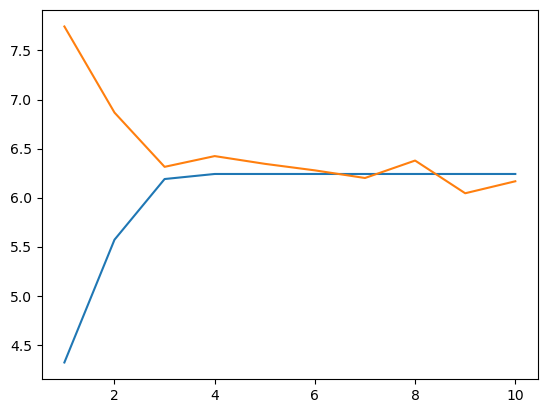

In [983]:
plot_bounds(dict_lower=v_lower, dict_upper=v_upper)

In [64]:
x[40][1][0]

array([3., 3.])

In [822]:
x, Q_, v_lower, v_upper = BL_SDDP(t_max=t_max, i_max=i_max, z_max=z_max, 
                                  p=p, q=q, 
                                  #S=S, 
                                  c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples, batch_size = batch_size,
                                  x_0 = x_0)

cut approximations initialized
Iteration 1:
Sampled scenarios: [(0, 0, 2, 2), (0, 0, 0, 2), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 0, 1), (0, 0, 1, 2), (0, 0, 1, 2), (0, 0, 1, 1), (0, 0, 1, 1), (0, 0, 0, 1), (0, 0, 0, 0), (0, 0, 0, 2), (0, 0, 0, 0), (0, 0, 2, 0), (0, 0, 0, 0), (0, 0, 0, 2), (0, 0, 2, 0), (0, 0, 0, 0), (0, 0, 2, 0), (0, 0, 2, 2), (0, 0, 0, 1), (0, 0, 2, 2), (0, 0, 2, 0), (0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 1), (0, 0, 1, 1), (0, 0, 0, 0), (0, 0, 2, 0), (0, 0, 0, 0), (0, 0, 0, 2), (0, 0, 0, 1), (0, 0, 2, 1), (0, 0, 2, 0), (0, 0, 0, 2), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 0, 2), (0, 0, 1, 2), (0, 0, 0, 2), (0, 0, 0, 2), (0, 0, 2, 1), (0, 0, 0, 1), (0, 0, 0, 1), (0, 0, 1, 2), (0, 0, 2, 1), (0, 0, 1, 0), (0, 0, 1, 2), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 2, 1), (0, 0, 1, 0), (0, 0, 1, 0), (0, 0, 0, 1), (0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 1, 2), (0, 0, 2, 0), (0, 0, 2, 2), (0, 0, 1, 0), (0, 0, 2, 0), (0, 0, 1, 2), (0, 0, 2, 2), (0, 0, 0, 1), (0, 0, 1, 0), (0, 0, 0, 2)

In [67]:
x[40][1][0]

array([3., 3.])

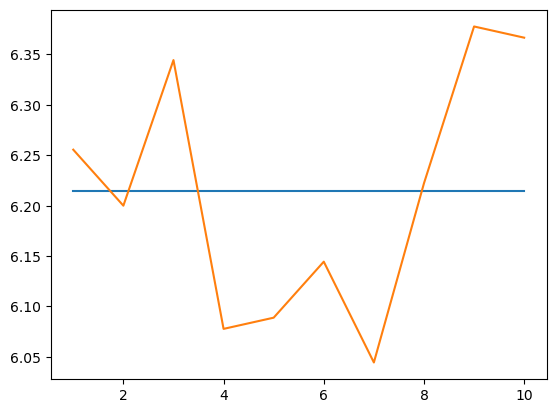

In [823]:
plot_bounds(v_lower, v_upper)

## Energy example - simple

In [875]:
## INPUT

t_max = 8 #24

# Uncertainty
q = {t: 2 for t in range(2,t_max+1)}
q[1] = 1

p = {t: np.array([0.5,0.5]) for t in range(2,t_max+1)}

S = generate_scenarios(q=q, t_max=t_max)
print(f"No. of scenarios: {len(S)}")

# Parameters
from_grid_max = 25
to_grid_max = 25
soc_max = 100

price_from_grid = {t: {} for t in range(1,t_max+1)}
price_to_grid = {t: {} for t in range(1,t_max+1)}
gen_less_demand = {t: {} for t in range(1,t_max+1)}

for t in range(1, 2):
    price_from_grid[t] = {0: 0.3}
    price_to_grid[t] = {0: 0.15}
    gen_less_demand[t] = {0: 0}

for t in range(2, 7):
    price_from_grid[t] = {0: 0.2, 1: 0.4}
    price_to_grid[t] = {0: 0.1, 1: 0.2} 
    gen_less_demand[t] = {0: 0, 1: 10}

for t in range(7, t_max+1):
    price_from_grid[t] = {0: 0.4, 1: 0.6}
    price_to_grid[t] = {0: 0.2, 1: 0.4}
    gen_less_demand[t] = {0: -20, 1: -5}

# Initial condition
x_0 = np.array([0,0,10,0,0,0])
# x_0 = [s^+, s^-, SoC, u^+,  u^-, u^SoC]

# Generate input represenation
c = {}
W = {}
h = {}
T = {}
for t in range(1,t_max+1):
    c[t] = {}
    W[t] = {}
    h[t] = {}
    T[t-1] = {}
    for j in range(q[t]):
        c[t][j] = np.array([price_from_grid[t][j], -price_to_grid[t][j], 0, 0, 0, 0])
        W[t][j] = np.array([ [-1, 1, 1, 0, 0, 0], [1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1] ])
        h[t][j] = np.array([gen_less_demand[t][j], from_grid_max, to_grid_max, soc_max])
        T[t-1][j] = np.array([ [0, 0, -1, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0] ])


No. of scenarios: 128


In [765]:
sys.getsizeof(S)

4696

In [876]:
# Algorithm parameters
i_max = 12
no_of_samples = 32
z_max = no_of_samples * 5
batch_size = 30
phi_list = [-20 for t in range(1, t_max+1)]
phi_ = np.array([0,*phi_list])

In [877]:
result_sddp = {}
result_sddp['i_max'] = i_max
result_sddp['no_of_samples'] = no_of_samples
result_sddp['phi_'] = phi_

In [878]:
result_sddp["x"], result_sddp["Q_"], result_sddp["v_lower"], result_sddp["v_upper"] = SDDP(t_max=t_max, i_max=i_max,
                                  p=p, q=q, 
                                  #S=S, 
                                  c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples,
                                  x_0 = x_0)

cut approximations initialized
Forward pass: 1
v upper 1: 4.9375, sigma v upper 1: 0.8375481449811052
v lower 1: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 2
v upper 2: -1.9090909090909078, sigma v upper 2: 0.8279395334006837
v lower 2: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 3
v upper 3: -2.0, sigma v upper 3: 0.9837387536759294
v lower 3: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 4
v upper 4: -1.875, sigma v upper 4: 0.8864458755742398
v lower 4: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 5
v upper 5: 0.5625, sigma v upper 5: 0.9417912540096305
v lower 5: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 6
v upper 6: -1.375, sigma v upper 6: 0.8703795056588636
v lower 6: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 7
v upper 7: -2.6875, sigma v upper 7: 0.9561320557666269
v lower 7: -1.5
[  0.  10.   0.  25.  15. 100.]
0.0
Forward pass: 8
v upper 8: -0.75, sigma v upper 8: 0.8069756361993556
v lower 8: -1.5
[  0.  10.

In [472]:
with open("result_sddp_5.pkl", 'wb') as handle:
    pickle.dump(result_sddp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [476]:
with open("result_sddp_5.pkl", 'rb') as handle:
    result_sddp = pickle.load(handle)

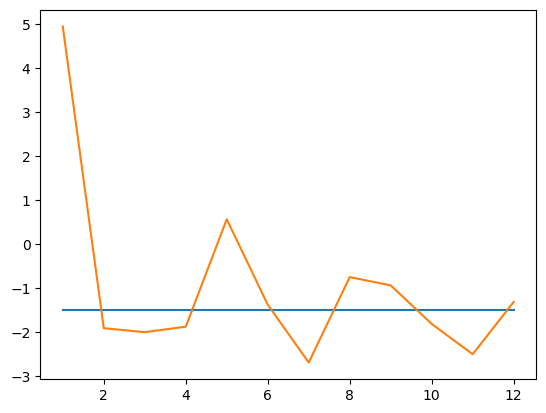

In [879]:
plot_bounds(result_sddp["v_lower"], result_sddp["v_upper"]) #Alg took 1m 17s

In [60]:
result_sddp["x"][5][1][0]

array([ 0.,  0., 10., 25., 25., 90.])

In [177]:
result_blsddp = {}
result_blsddp['i_max'] = i_max
result_blsddp['z_max'] = z_max
result_blsddp["batch_size"] = batch_size
result_blsddp['no_of_samples'] = no_of_samples
result_blsddp['phi_'] = phi_

In [173]:

result_blsddp["x"], result_blsddp["Q_"], result_blsddp["v_lower"], result_blsddp["v_upper"] = BL_SDDP(t_max=t_max, i_max=i_max, z_max=z_max, 
                                  p=p, q=q, S=S, c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples, batch_size = batch_size,
                                  x_0 = x_0)

cut approximations initialized
dicts initialized, 8388608 scenarios
Iteration 1:
Sampled scenarios: [2034374, 7905583, 574644, 2378788, 4166769, 4797557, 3972151, 995921, 6097517, 1443432, 799423, 1854236, 352495, 1912678, 6972893, 131332, 4486611, 3207172, 4022174, 81090, 2664478, 6050266, 7372180, 3996554, 7443637, 6839832, 2720488, 6836555, 7685018, 5599294, 8323930, 59902, 2856486, 1030327, 6508601, 7633419, 2457974, 7850241, 3906637, 5789113, 7623030, 7313416, 461490, 4649808, 897399, 5602127, 2404306, 1719303, 2004090, 7737336, 7659958, 169009, 3576369, 5495822, 4838896, 5504910, 7161024, 5353393, 2750255, 2895629, 8114595, 13054, 4220634, 6524641, 2499007, 6032609, 7117767, 554468, 1171988, 7507181, 1197873, 7245458, 4834210, 3743270, 1876802, 5028878, 2958229, 8059825, 3284982, 4836280, 2150782, 3126196, 3821661, 4147929, 1583330, 3906048, 2123365, 4677069, 4184694, 2195836, 5587773, 471873, 8147157, 7806765, 7145609, 5436708, 172376, 5313815, 1792244, 3403278]
v upper 1: 93.65

In [26]:
result_blsddp["x"][5][1][0]

array([10.,  0., 20., 15., 25., 80.])

In [178]:
with open("result_blsddp_4.pkl", 'wb') as handle:
    pickle.dump(result_blsddp, handle, protocol=pickle.HIGHEST_PROTOCOL)

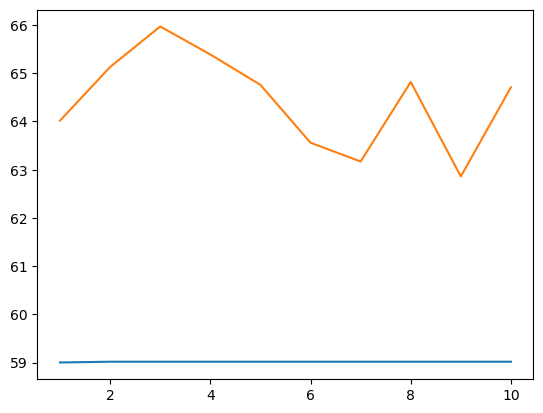

In [179]:
plot_bounds(result_blsddp['v_lower'], result_blsddp['v_upper']) # Alg took 6m 43s

## Energy example - larger

In [77]:
input_data = pd.read_excel("input_data.xlsx", nrows=48)

In [79]:
input_data.head(10)

,slp_uebergang_mid-W,slp_uebergang_low,slp_uebergang_mid,slp_uebergang_high,price_from_grid_low,price_from_grid_mid,price_from_grid_high,price_from_backup,price_to_grid_low,price_to_grid_mid,price_to_grid_high,generation_base,epsilon_g_0.2,Unnamed: 13,epsilon_g_mid,Unnamed: 15,epsilon_g_0.8,soc_min_sh
0,66.6,0.27972,0.3996,0.51948,0.28,0.4,0.52,1,0.18,0.3,0.42,0.000000,0.000000,NaN,0,NaN,0.000000,0.1
1,49.2,0.20664,0.2952,0.38376,0.28,0.4,0.52,1,0.18,0.3,0.42,0.000000,0.000000,NaN,0,NaN,0.000000,0.1
2,44.3,0.18606,0.2658,0.34554,0.28,0.4,0.52,1,0.18,0.3,0.42,0.000000,0.000000,NaN,0,NaN,0.000000,0.2
3,43.1,0.18102,0.2586,0.33618,0.28,0.4,0.52,1,0.18,0.3,0.42,0.000000,0.000000,NaN,0,NaN,0.000000,0.2
4,44.1,0.18522,0.2646,0.34398,0.28,0.4,0.52,1,0.18,0.3,0.42,0.000988,-0.103866,NaN,0,NaN,0.103866,0.2
5,52.6,0.22092,0.3156,0.41028,0.35,0.5,0.65,1,0.25,0.4,0.55,0.026422,-0.103866,NaN,0,NaN,0.103866,0.2
6,92.9,0.39018,0.5574,0.72462,0.28,0.4,0.52,1,0.18,0.3,0.42,0.118515,-0.103866,NaN,0,NaN,0.103866,0.2
7,130.0,0.54600,0.7800,1.01400,0.14,0.2,0.26,1,0.04,0.1,0.16,0.250777,-0.103866,NaN,0,NaN,0.103866,0.2
8,137.0,0.57540,0.8220,1.06860,0.14,0.2,0.26,1,0.04,0.1,0.16,0.372982,-0.103866,NaN,0,NaN,0.103866,0.2
9,136.0,0.57120,0.8160,1.06080,0.14,0.2,0.26,1,0.04,0.1,0.16,0.462552,-0.103866,NaN,0,NaN,0.103866,0.2


In [80]:
input_data.shape

(48, 18)

In [102]:
## INPUT

t_max = 24
assert t_max <= input_data.shape[0]


## Parameters
from_grid_max = 20
price_from_grid_levels = ['low', 'mid', 'high']
to_grid_max = 20
soc_max = 60
kWp_installed = 10

theta_g_const = 0.65
sigma_g = 0.0742

theta_d_const = 0
demand_levels = ['low', 'mid', 'high']

soc_min = {t: soc_max * input_data.loc[t-1, 'soc_min_sh'] for t in range(1,t_max+1)}

price_from_grid = {t: {} for t in range(1,t_max+1)}
price_to_grid = {t: {} for t in range(1,t_max+1)}

g_base = {t: input_data.loc[t-1, 'generation_base'] for t in range(1,t_max+1)}
g_base[0] = 0

epsilon_g = {t: {} for t in range(1,t_max+1)}
theta_g = {t:  theta_g_const for t in range(1, t_max+1)} #0.65

with open('standard_normal_quantization.pkl', 'rb') as f:
    standardnormal_quantization = pickle.load(f)
epsilon_g_quantization = [sigma_g * s for s in standardnormal_quantization]


price_from_backup = {t: input_data.loc[t-1, 'price_from_backup'] for t in range(1,t_max+1)}

demand = {t: {} for t in range(1,t_max+1)}
theta_d = {t: theta_d_const for t in range(1, t_max+1)}



## Scenario generation
q_t = len(price_from_grid_levels)*len(demand_levels)*len(epsilon_g_quantization)

q = {t: q_t for t in range(2,t_max+1)}
q[1] = 1

p = {t: np.array([1/q[t] for j in range(q[t])]) for t in range(2,t_max+1)}

for t in range(2, t_max):
    assert round(sum(p[t]), 10) == 1


no_of_scenarios = pow(q_t, t_max)

assert no_of_scenarios == pow(q_t, t_max)
print(f"No. of scenarios: {no_of_scenarios}; per stage: {q_t}")



for t in range(1, 2):
    price_from_grid[t] = {0: input_data.loc[t-1, 'price_from_grid_mid']}

    price_to_grid[t] = {0: input_data.loc[t-1, 'price_to_grid_mid']}

    demand[t] = {0: input_data.loc[t-1, 'slp_uebergang_mid']}

    epsilon_g[t] = {0: 0}


for t in range(2, t_max+1):
    scenario_index = 0
    for price_from_grid_level in price_from_grid_levels:
        for demand_level in demand_levels:
            for epsilon_g_realization in epsilon_g_quantization:
                price_from_grid[t][scenario_index] = input_data.loc[t-1, f'price_from_grid_{price_from_grid_level}']
                price_to_grid[t][scenario_index] = input_data.loc[t-1, f'price_to_grid_{price_from_grid_level}']
                demand[t][scenario_index] = input_data.loc[t-1, f'slp_uebergang_{demand_level}']
                epsilon_g[t][scenario_index] = epsilon_g_realization
                
                scenario_index = scenario_index + 1
    
    assert scenario_index == q[t], f'{t}'
                
                

    
    

# Initial condition
# x_0 = [s^+, s^++, s^-, s^--, SoC, u^+,  u^-, u^SoC+, u^SoC- g, d]
x_0 = np.array([0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0])


# Generate input represenation
c = {}
W = {}
h = {}
T = {}

for t in range(1,t_max+1):
    c[t] = {}
    W[t] = {}
    h[t] = {}
    T[t-1] = {}
    
    for j in range(q[t]):
        
        assert price_from_grid[t][j] > price_to_grid[t][j], f"t: {t}, j: {j}"
        
        c[t][j] = np.array([price_from_grid[t][j], price_from_backup[t], -price_to_grid[t][j], 0, 0, 0, 0, 0, 0, 0, 0])

        W[t][j] = np.array([[-1, -1, 1, 1, 1, 0, 0, 0, 0, -1, 1], 
                            [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 
                            [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], 
                            [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
                            [0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
                            ])
        
        h[t][j] = np.array([0,
                            from_grid_max, 
                            to_grid_max, 
                            soc_max,
                            soc_min[t],
                            kWp_installed * min(max(g_base[t] + epsilon_g[t][j] - theta_g[t]*g_base[t-1], 0), 1),
                            demand[t][j]
                            ])
        
        T[t-1][j] = np.array([[0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0], 
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, -theta_g[t], 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -theta_d[t]]
                                 ])

No. of scenarios: 6362685441135942358474828762538534230890216321; per stage: 81


In [103]:
# Algorithm parameters
i_max = 4
no_of_samples = 10
z_max = no_of_samples * 5
batch_size = 5
phi_list = [-100 for t in range(1, t_max+1)]
phi_ = np.array([0,*phi_list])

In [104]:
result_sddp = {}
result_sddp['i_max'] = i_max
result_sddp['no_of_samples'] = no_of_samples
result_sddp['phi_'] = phi_

In [105]:
result_sddp["x"], result_sddp["Q_"], result_sddp["v_lower"], result_sddp["v_upper"] = SDDP(t_max=t_max, i_max=i_max,
                                  p=p, q=q, 
                                  #S=S, 
                                  c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples,
                                  x_0 = x_0)

Forward pass: 1
v upper 1: 16.274243909678084, sigma v upper 1: 0.7752865945029633
v lower 1: -97.3501226409534
stage 1 cost: 0.5598399999999998
phi value: -97.9099626409534
Forward pass: 2
v upper 2: 8.401362119732385, sigma v upper 2: 0.7550399015994572
v lower 2: -21.149128414393687
stage 1 cost: 8.0
phi value: -29.149128414393687
Forward pass: 3
v upper 3: 3.884310613150423, sigma v upper 3: 2.4320325196584145
v lower 3: -14.784617840410471
stage 1 cost: 0.5598399999999998
phi value: -15.34445784041047
Forward pass: 4
v upper 4: -2.645635429705854, sigma v upper 4: 1.593221492398499
v lower 4: -11.336034589519471
stage 1 cost: 8.0
phi value: -19.33603458951947


In [192]:
with open("result_sddp_large_1.pkl", 'wb') as handle:
    pickle.dump(result_sddp, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [694]:
costs = []
for scenario in range():
    cost = []
    for t in range(1, t_max+1):
        k = S[scenario][t]
        cost.append(np.dot(c[t][k], result_sddp["x"][result_sddp['i_max']][t][scenario]))
    costs.append(sum(cost))

KeyError: 0

In [673]:
np.mean(costs)

-1.4863421369539307

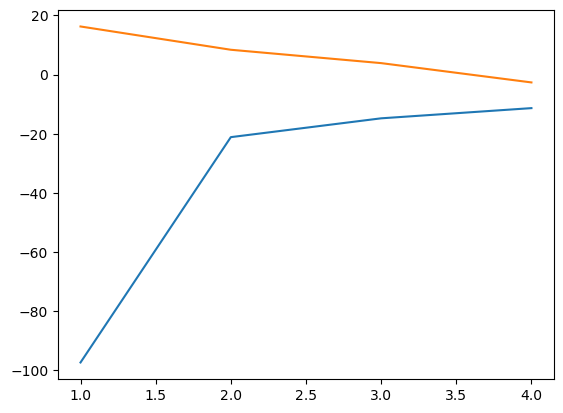

In [106]:
plot_bounds(result_sddp['v_lower'], result_sddp['v_upper'])

In [54]:
result_blsddp = {}
result_blsddp['i_max'] = i_max
result_blsddp['z_max'] = z_max
result_blsddp["batch_size"] = batch_size
result_blsddp['no_of_samples'] = no_of_samples
result_blsddp['phi_'] = phi_

In [55]:
result_blsddp["x"], result_blsddp["Q_"], result_blsddp["v_lower"], result_blsddp["v_upper"] = BL_SDDP(t_max=t_max, i_max=i_max, z_max=z_max, 
                                  p=p, q=q, S=S, c=c, W=W, h=h, T=T, 
                                  phi_ = phi_, no_of_samples = no_of_samples, batch_size = batch_size,
                                  x_0 = x_0)

NameError: name 'BL_SDDP' is not defined

In [193]:
with open("result_blsddp_large_1.pkl", 'wb') as handle:
    pickle.dump(result_blsddp, handle, protocol=pickle.HIGHEST_PROTOCOL)

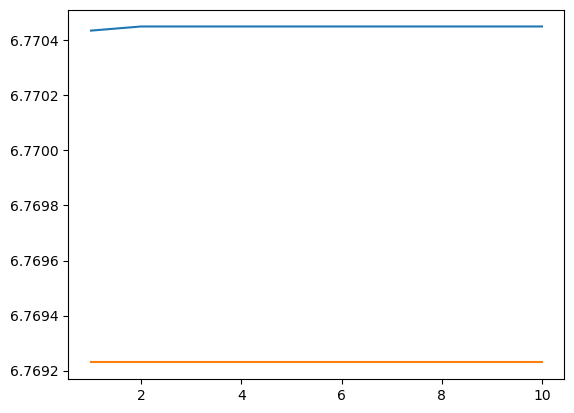

In [541]:
plot_bounds(result_blsddp['v_lower'], result_blsddp['v_upper'])

In [ ]:
# Old
    price_from_grid[t] = {0: input_data.loc[t-1, 'price_from_grid_low'], 
                          1: input_data.loc[t-1, 'price_from_grid_mid'], 
                          2: input_data.loc[t-1, 'price_from_grid_high'],
                          3: input_data.loc[t-1, 'price_from_grid_low'], 
                          4: input_data.loc[t-1, 'price_from_grid_mid'], 
                          5: input_data.loc[t-1, 'price_from_grid_high'],
                          6: input_data.loc[t-1, 'price_from_grid_low'], 
                          7: input_data.loc[t-1, 'price_from_grid_mid'], 
                          8: input_data.loc[t-1, 'price_from_grid_high'],
                          9: input_data.loc[t-1, 'price_from_grid_low'], 
                          10: input_data.loc[t-1, 'price_from_grid_mid'], 
                          11: input_data.loc[t-1, 'price_from_grid_high'],
                          12: input_data.loc[t-1, 'price_from_grid_low'], 
                          13: input_data.loc[t-1, 'price_from_grid_mid'], 
                          14: input_data.loc[t-1, 'price_from_grid_high'],
                          15: input_data.loc[t-1, 'price_from_grid_low'], 
                          16: input_data.loc[t-1, 'price_from_grid_mid'], 
                          17: input_data.loc[t-1, 'price_from_grid_high'],
                          18: input_data.loc[t-1, 'price_from_grid_low'], 
                          19: input_data.loc[t-1, 'price_from_grid_mid'], 
                          20: input_data.loc[t-1, 'price_from_grid_high'],
                          21: input_data.loc[t-1, 'price_from_grid_low'], 
                          22: input_data.loc[t-1, 'price_from_grid_mid'], 
                          23: input_data.loc[t-1, 'price_from_grid_high'],
                          24: input_data.loc[t-1, 'price_from_grid_low'], 
                          25: input_data.loc[t-1, 'price_from_grid_mid'], 
                          26: input_data.loc[t-1, 'price_from_grid_high']}
    
    price_to_grid[t] = {0: input_data.loc[t-1, 'price_to_grid_low'], 
                          1: input_data.loc[t-1, 'price_to_grid_mid'], 
                          2: input_data.loc[t-1, 'price_to_grid_high'],
                          3: input_data.loc[t-1, 'price_to_grid_low'], 
                          4: input_data.loc[t-1, 'price_to_grid_mid'], 
                          5: input_data.loc[t-1, 'price_to_grid_high'],
                          6: input_data.loc[t-1, 'price_to_grid_low'], 
                          7: input_data.loc[t-1, 'price_to_grid_mid'], 
                          8: input_data.loc[t-1, 'price_to_grid_high'],
                          9: input_data.loc[t-1, 'price_to_grid_low'], 
                          10: input_data.loc[t-1, 'price_to_grid_mid'], 
                          11: input_data.loc[t-1, 'price_to_grid_high'],
                          12: input_data.loc[t-1, 'price_to_grid_low'], 
                          13: input_data.loc[t-1, 'price_to_grid_mid'], 
                          14: input_data.loc[t-1, 'price_to_grid_high'],
                          15: input_data.loc[t-1, 'price_to_grid_low'], 
                          16: input_data.loc[t-1, 'price_to_grid_mid'], 
                          17: input_data.loc[t-1, 'price_to_grid_high'],
                          18: input_data.loc[t-1, 'price_to_grid_low'], 
                          19: input_data.loc[t-1, 'price_to_grid_mid'], 
                          20: input_data.loc[t-1, 'price_to_grid_high'],
                          21: input_data.loc[t-1, 'price_to_grid_low'], 
                          22: input_data.loc[t-1, 'price_to_grid_mid'], 
                          23: input_data.loc[t-1, 'price_to_grid_high'],
                          24: input_data.loc[t-1, 'price_to_grid_low'], 
                          25: input_data.loc[t-1, 'price_to_grid_mid'], 
                          26: input_data.loc[t-1, 'price_to_grid_high']}
    
    
    demand[t] = {0: input_data.loc[t-1, 'slp_uebergang_low'],
                 1: input_data.loc[t-1, 'slp_uebergang_low'],
                 2: input_data.loc[t-1, 'slp_uebergang_low'],
                    3: input_data.loc[t-1, 'slp_uebergang_mid'],
                    4: input_data.loc[t-1, 'slp_uebergang_mid'],
                    5: input_data.loc[t-1, 'slp_uebergang_mid'], 
                    6: input_data.loc[t-1, 'slp_uebergang_high'],
                    7: input_data.loc[t-1, 'slp_uebergang_high'],
                    8: input_data.loc[t-1, 'slp_uebergang_high'],
                    9: input_data.loc[t-1, 'slp_uebergang_low'],
                    10: input_data.loc[t-1, 'slp_uebergang_low'],
                    11: input_data.loc[t-1, 'slp_uebergang_low'],
                    12: input_data.loc[t-1, 'slp_uebergang_mid'],
                    13: input_data.loc[t-1, 'slp_uebergang_mid'],
                    14: input_data.loc[t-1, 'slp_uebergang_mid'], 
                    15: input_data.loc[t-1, 'slp_uebergang_high'],
                    16: input_data.loc[t-1, 'slp_uebergang_high'],
                    17: input_data.loc[t-1, 'slp_uebergang_high'],
                    18: input_data.loc[t-1, 'slp_uebergang_low'],
                    19: input_data.loc[t-1, 'slp_uebergang_low'],
                    20: input_data.loc[t-1, 'slp_uebergang_low'],
                    21: input_data.loc[t-1, 'slp_uebergang_mid'],
                    22: input_data.loc[t-1, 'slp_uebergang_mid'],
                    23: input_data.loc[t-1, 'slp_uebergang_mid'], 
                    24: input_data.loc[t-1, 'slp_uebergang_high'],
                    25: input_data.loc[t-1, 'slp_uebergang_high'],
                    26: input_data.loc[t-1, 'slp_uebergang_high']}
    
    epsilon_g[t] = {0: input_data.loc[t-1, 'epsilon_g_low'],
                    1: input_data.loc[t-1, 'epsilon_g_low'],
                    2: input_data.loc[t-1, 'epsilon_g_low'],
                    3: input_data.loc[t-1, 'epsilon_g_low'],
                    4: input_data.loc[t-1, 'epsilon_g_low'],
                    5: input_data.loc[t-1, 'epsilon_g_low'], 
                    6: input_data.loc[t-1, 'epsilon_g_low'],
                    7: input_data.loc[t-1, 'epsilon_g_low'],
                    8: input_data.loc[t-1, 'epsilon_g_low'],
                    9: input_data.loc[t-1, 'epsilon_g_mid'],
                    10: input_data.loc[t-1, 'epsilon_g_mid'],
                    11: input_data.loc[t-1, 'epsilon_g_mid'],
                    12: input_data.loc[t-1, 'epsilon_g_mid'],
                    13: input_data.loc[t-1, 'epsilon_g_mid'],
                    14: input_data.loc[t-1, 'epsilon_g_mid'], 
                    15: input_data.loc[t-1, 'epsilon_g_mid'],
                    16: input_data.loc[t-1, 'epsilon_g_mid'],
                    17: input_data.loc[t-1, 'epsilon_g_mid'],
                    18: input_data.loc[t-1, 'epsilon_g_high'],
                    19: input_data.loc[t-1, 'epsilon_g_high'],
                    20: input_data.loc[t-1, 'epsilon_g_high'],
                    21: input_data.loc[t-1, 'epsilon_g_high'],
                    22: input_data.loc[t-1, 'epsilon_g_high'],
                    23: input_data.loc[t-1, 'epsilon_g_high'], 
                    24: input_data.loc[t-1, 'epsilon_g_high'],
                    25: input_data.loc[t-1, 'epsilon_g_high'],
                    26: input_data.loc[t-1, 'epsilon_g_high']}